# Interpolacja wielomianowa


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math 
plt.style.use('seaborn-poster')

%matplotlib inline


In [6]:
def divided_diff(x, y):
    '''
    function to calculate the divided
    differences table
    '''
    n = len(y)
    coef = np.zeros([n, n])
    # the first column is y
    coef[:,0] = y
    
    for j in range(1,n):
        for i in range(n-j):
            coef[i][j] = \
           (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j]-x[i])
            
    return coef

def newton_poly(coef, x_data, x):
    '''
    evaluate the newton polynomial 
    at x
    '''
    n = len(x_data) - 1 
    p = coef[n]
    for k in range(1,n+1):
        p = coef[n-k] + (x -x_data[n-k])*p
    return p

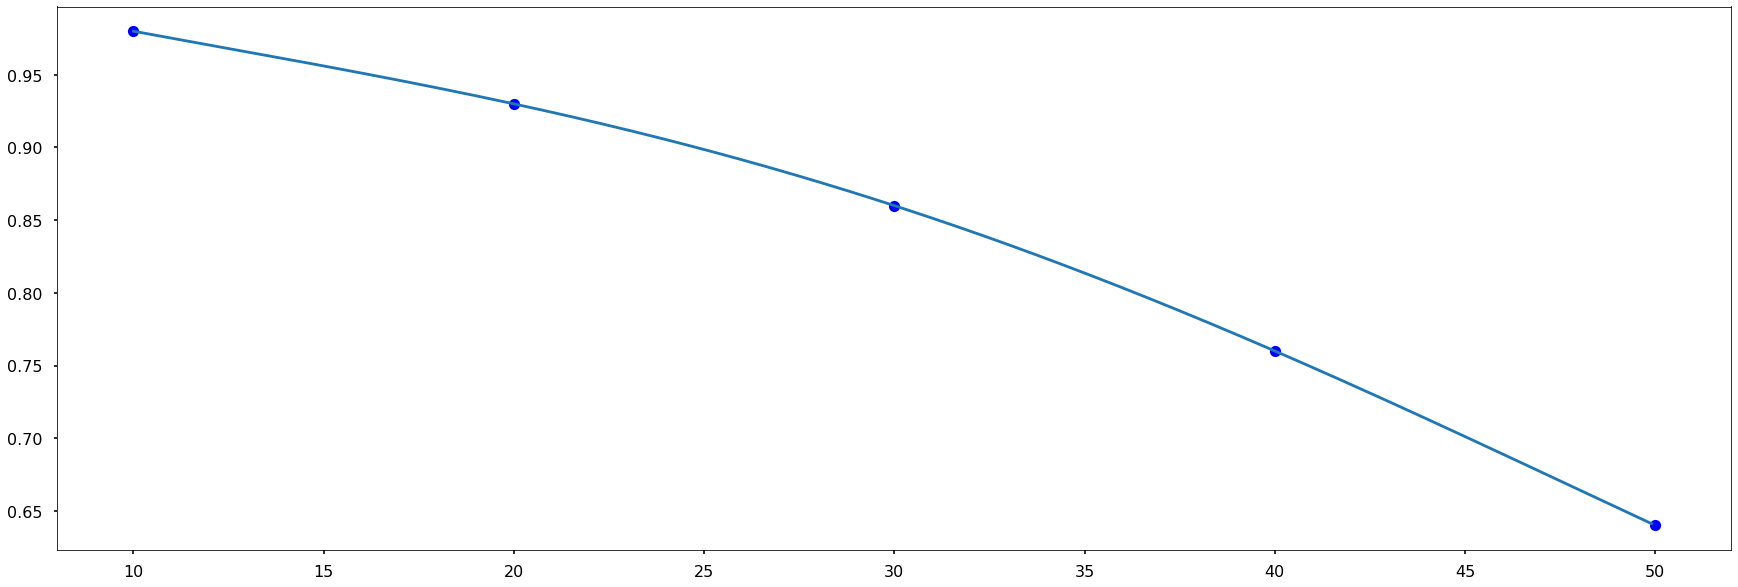

In [12]:
x = np.array([10,20,30,40,50])
y = np.array(([0.98, 0.93, 0.86, 0.76,0.64]))
#y = np.array([math.cos(0.98)])
# get the divided difference coef
a_s = divided_diff(x, y)[0, :]

# evaluate on new data points
x_new = np.arange(10, 50, .1)
y_new = newton_poly(a_s, x, x_new)

plt.figure(figsize = (30, 10))
plt.plot(x, y, 'bo')
plt.plot(x_new, y_new)


In [10]:
from typing import Tuple, List
import bisect

def compute_changes(x: List[float]) -> List[float]:
    return [x[i+1] - x[i] for i in range(len(x) - 1)]

def create_tridiagonalmatrix(n: int, h: List[float]) -> Tuple[List[float], List[float], List[float]]:
    A = [h[i] / (h[i] + h[i + 1]) for i in range(n - 2)] + [0]
    B = [2] * n
    C = [0] + [h[i + 1] / (h[i] + h[i + 1]) for i in range(n - 2)]
    return A, B, C

def create_target(n: int, h: List[float], y: List[float]):
    return [0] + [6 * ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1]) / (h[i] + h[i-1]) for i in range(1, n - 1)] + [0]

def solve_tridiagonalsystem(A: List[float], B: List[float], C: List[float], D: List[float]):
    c_p = C + [0]
    d_p = [0] * len(B)
    X = [0] * len(B)

    c_p[0] = C[0] / B[0]
    d_p[0] = D[0] / B[0]
    for i in range(1, len(B)):
        c_p[i] = c_p[i] / (B[i] - c_p[i - 1] * A[i - 1])
        d_p[i] = (D[i] - d_p[i - 1] * A[i - 1]) / (B[i] - c_p[i - 1] * A[i - 1])

    X[-1] = d_p[-1]
    for i in range(len(B) - 2, -1, -1):
        X[i] = d_p[i] - c_p[i] * X[i + 1]

    return X

def compute_spline(x: List[float], y: List[float]):
    n = len(x)
    if n < 3:
        raise ValueError('Too short an array')
    if n != len(y):
        raise ValueError('Array lengths are different')

    h = compute_changes(x)
    if any(v < 0 for v in h):
        raise ValueError('X must be strictly increasing')

    A, B, C = create_tridiagonalmatrix(n, h)
    D = create_target(n, h, y)

    M = solve_tridiagonalsystem(A, B, C, D)

    coefficients = [[(M[i+1]-M[i])*h[i]*h[i]/6, M[i]*h[i]*h[i]/2, (y[i+1] - y[i] - (M[i+1]+2*M[i])*h[i]*h[i]/6), y[i]] for i in range(n-1)]

    def spline(val):
        idx = min(bisect.bisect(x, val)-1, n-2)
        z = (val - x[idx]) / h[idx]
        C = coefficients[idx]
        return (((C[0] * z) + C[1]) * z + C[2]) * z + C[3]

    return spline

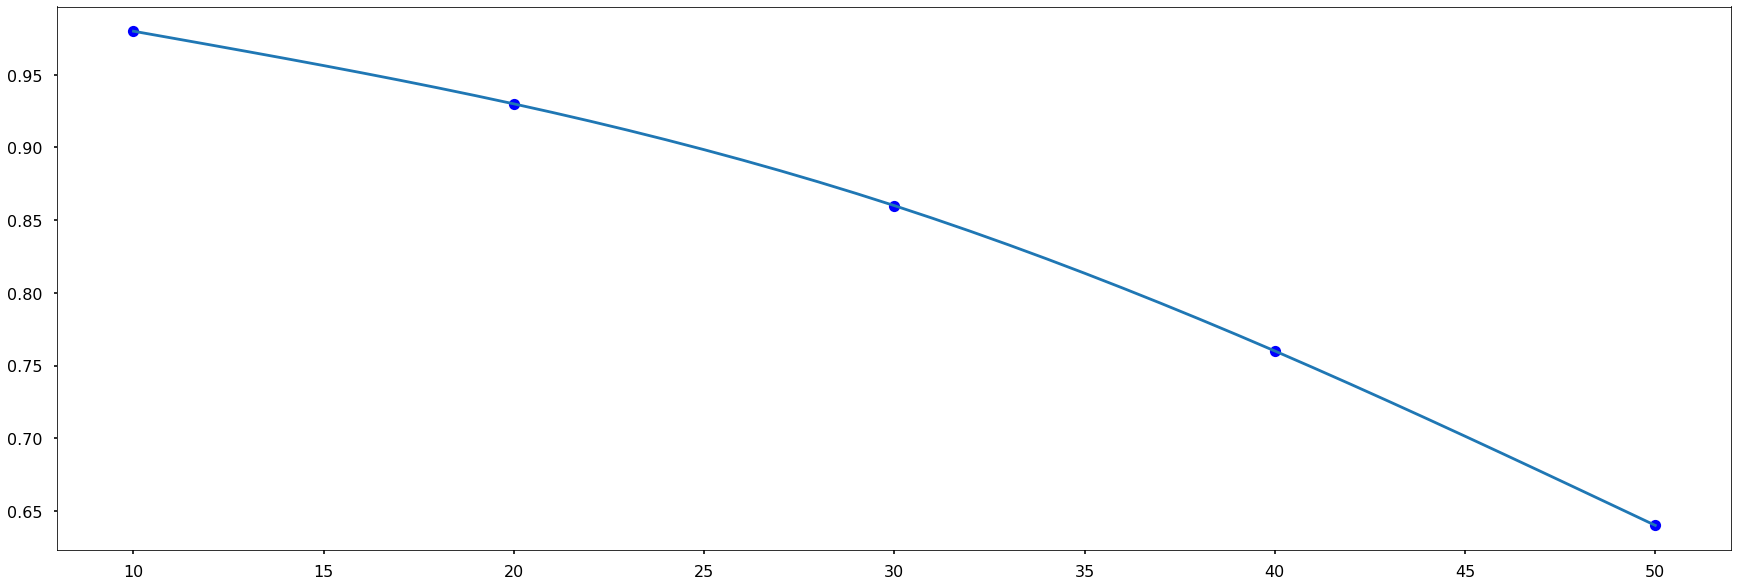

In [11]:
import matplotlib.pyplot as plt

test_x = [10,20,30,40,50]
test_y = [0.98, 0.93, 0.86, 0.76,0.64]
spline = compute_spline(test_x, test_y)

for i, x in enumerate(test_x):
    assert abs(test_y[i] - spline(x)) < 1e-8, f'Error at {x}, {test_y[i]}'

x_vals = [v for v in range(10, 51, 1)]
y_vals = [spline(y) for y in x_vals]

plt.figure(figsize = (30, 10))
plt.plot(test_x, test_y, 'bo')
plt.plot(x_vals, y_vals)

# Macierze własne macierzy